In [1]:
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
import torchvision
import copy

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)

In [4]:
transform = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (1,))
                               ])
mnist_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
data_loader_train = DataLoader(mnist_trainset, 64, shuffle=True, num_workers=8)
data_loader_test = DataLoader(mnist_testset, 64, shuffle=True, num_workers=8)

Files already downloaded and verified


In [16]:
import RestNet
model = RestNet.ResNet18().to(device)
criterion = F.cross_entropy

In [52]:
# model = torchvision.models.resnet18(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 10)
# model = model.to(device)

### Find learning rate

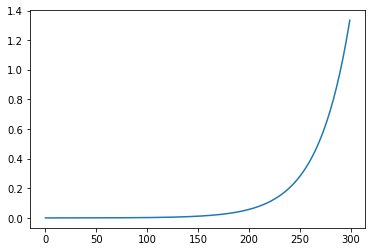

In [9]:
import math
lrs = []
for i in [x for x in range(300)]:
    lr = math.pow(1.1, i/3) / 10000
    lrs.append(lr)
plt.plot(lrs)

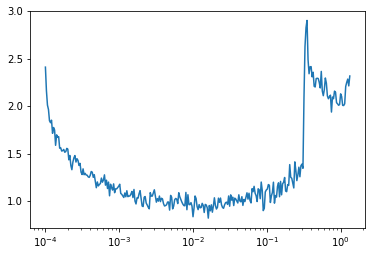

In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses = []
model.train()
def is_running():
    return len(losses) < len(lrs)
count = 0
batch_num = 10
while is_running():
    for i, (data, target) in enumerate(data_loader_train):
        if count == 0:
            loss_accumulate = 0
            for param_group in optimizer.param_groups:
                param_group['lr'] = lrs[len(losses)]

        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss_accumulate += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if count == batch_num:
            losses.append(loss_accumulate/batch_num)
            count = -1
        if not is_running(): break
        count += 1
        
plt.semilogx(lrs, losses)

### Learning Rates [Choose one]
1. Different LR [worse] (maybe we have to use log scale)

In [60]:
lr = 0.001
num_children = len([c for c in model.children()])
param_groups = []
for i, child in enumerate(model.children()):
    denorm = num_children-i
    param_groups.append({
        'params': child.parameters(), 'lr': lr/denorm
    })
optimizer = optim.Adam(param_groups, lr=0.001, weight_decay=0.0) #weight_decay (L2 regularization) makes thing worse

In [61]:
for param_group in optimizer.param_groups:
    print(param_group['lr'])

0.00014285714285714287
0.00016666666666666666
0.0002
0.00025
0.0003333333333333333
0.0005
0.001


2. Static Learning Rate

In [65]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Train

In [62]:
def get_num_correct(output, target):
    # max of dimension 1, keepdim, and [0] is value / [1] is index (we need only index)
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct = pred.eq(target.view_as(pred)).sum().item()
    return correct

In [66]:
losses = []
def train(epoch):
    model.train()
    for i, (data, target) in enumerate(data_loader_train):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = F.cross_entropy(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i%100 == 0:
            print(f'epoch: {epoch}, i: {i}, loss: {loss.item()}')
            losses.append(loss.item())
            
        if i == len(data_loader_train)-1:
            correct = get_num_correct(output, target)
            print(f'training set last batch acc: {100. * correct / data.shape[0]}')
def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader_test:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss, default is mean
            correct += get_num_correct(output, target)
    test_loss /= len(data_loader_test.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(data_loader_test.dataset),
        100. * correct / len(data_loader_test.dataset)))
    
for epoch in range(10):
    train(epoch)
    test(epoch)
    
    

epoch: 0, i: 0, loss: 2.3027286529541016
epoch: 0, i: 100, loss: 1.5100959539413452
epoch: 0, i: 200, loss: 1.3491932153701782
epoch: 0, i: 300, loss: 1.179503321647644
epoch: 0, i: 400, loss: 1.1511296033859253
epoch: 0, i: 500, loss: 1.4289417266845703
epoch: 0, i: 600, loss: 1.0257619619369507
epoch: 0, i: 700, loss: 1.097969889640808
training set last batch acc: 62.5

Test set: Average loss: -3.2426, Accuracy: 6636/10000 (66.36%)

epoch: 1, i: 0, loss: 0.9795337915420532
epoch: 1, i: 100, loss: 0.8168318271636963
epoch: 1, i: 200, loss: 0.9601441025733948
epoch: 1, i: 300, loss: 0.6688312888145447
epoch: 1, i: 400, loss: 0.7390273213386536
epoch: 1, i: 500, loss: 0.6067075729370117
epoch: 1, i: 600, loss: 0.7342526316642761
epoch: 1, i: 700, loss: 0.6065990328788757
training set last batch acc: 62.5

Test set: Average loss: -4.2356, Accuracy: 7674/10000 (76.74%)

epoch: 2, i: 0, loss: 0.631231427192688
epoch: 2, i: 100, loss: 0.383542001247406
epoch: 2, i: 200, loss: 0.435830295085

epoch: 0, i: 0, loss: 1.9372303485870361
epoch: 0, i: 100, loss: 2.0781328678131104
epoch: 0, i: 200, loss: 1.7745529413223267
epoch: 0, i: 300, loss: 1.8100001811981201
epoch: 0, i: 400, loss: 1.8074313402175903
epoch: 0, i: 500, loss: 1.6106815338134766
epoch: 0, i: 600, loss: 1.8067936897277832
epoch: 0, i: 700, loss: 1.9162516593933105
training set last batch acc: 31.25

Test set: Average loss: -0.8058, Accuracy: 3273/10000 (32.73%)

epoch: 1, i: 0, loss: 1.955923318862915
epoch: 1, i: 100, loss: 1.5723577737808228
epoch: 1, i: 200, loss: 1.5829395055770874
epoch: 1, i: 300, loss: 1.7195405960083008
epoch: 1, i: 400, loss: 1.6098442077636719
epoch: 1, i: 500, loss: 1.6989620923995972
epoch: 1, i: 600, loss: 1.4761927127838135
epoch: 1, i: 700, loss: 1.6192255020141602
training set last batch acc: 43.75

Test set: Average loss: -0.8359, Accuracy: 3412/10000 (34.12%)

epoch: 2, i: 0, loss: 1.6493217945098877
epoch: 2, i: 100, loss: 1.607711672782898
epoch: 2, i: 200, loss: 1.5920279026031494
epoch: 2, i: 300, loss: 1.471415638923645
epoch: 2, i: 400, loss: 1.5355712175369263
epoch: 2, i: 500, loss: 1.8134037256240845
epoch: 2, i: 600, loss: 1.6875543594360352
epoch: 2, i: 700, loss: 1.7968285083770752
training set last batch acc: 43.75

Test set: Average loss: -0.9376, Accuracy: 3964/10000 (39.64%)

epoch: 3, i: 0, loss: 1.440176010131836
epoch: 3, i: 100, loss: 1.5044665336608887
epoch: 3, i: 200, loss: 1.4055570363998413
epoch: 3, i: 300, loss: 1.3688474893569946
epoch: 3, i: 400, loss: 1.4185792207717896
epoch: 3, i: 500, loss: 1.272760272026062
epoch: 3, i: 600, loss: 1.1619435548782349
epoch: 3, i: 700, loss: 1.0746163129806519
training set last batch acc: 50.0

Test set: Average loss: -1.1260, Accuracy: 6123/10000 (61.23%)

epoch: 4, i: 0, loss: 1.1414680480957031
epoch: 4, i: 100, loss: 1.039971947669983
epoch: 4, i: 200, loss: 1.0521355867385864
epoch: 4, i: 300, loss: 1.175338625907898
epoch: 4, i: 400, loss: 1.071406602859497
epoch: 4, i: 500, loss: 1.130670428276062
epoch: 4, i: 600, loss: 0.8909551501274109
epoch: 4, i: 700, loss: 0.8861261010169983
training set last batch acc: 56.25

Test set: Average loss: -1.2064, Accuracy: 6616/10000 (66.16%)

epoch: 5, i: 0, loss: 0.8181304931640625
epoch: 5, i: 100, loss: 0.9175812005996704
epoch: 5, i: 200, loss: 0.8948319554328918
epoch: 5, i: 300, loss: 1.282103419303894
epoch: 5, i: 400, loss: 1.282362461090088
epoch: 5, i: 500, loss: 0.907379150390625
epoch: 5, i: 600, loss: 0.8735712170600891
epoch: 5, i: 700, loss: 0.7083377838134766
training set last batch acc: 68.75

Test set: Average loss: -1.1505, Accuracy: 6836/10000 (68.36%)

epoch: 6, i: 0, loss: 0.8176227807998657
epoch: 6, i: 100, loss: 1.0804920196533203
epoch: 6, i: 200, loss: 1.0807372331619263
epoch: 6, i: 300, loss: 0.791027843952179
epoch: 6, i: 400, loss: 0.8846410512924194
epoch: 6, i: 500, loss: 0.9763593673706055
epoch: 6, i: 600, loss: 1.2476403713226318
epoch: 6, i: 700, loss: 0.8191957473754883
training set last batch acc: 56.25

Test set: Average loss: -1.0978, Accuracy: 7061/10000 (70.61%)

epoch: 7, i: 0, loss: 0.7772191762924194
epoch: 7, i: 100, loss: 0.7814069986343384
epoch: 7, i: 200, loss: 0.8066980838775635
epoch: 7, i: 300, loss: 0.8930161595344543
epoch: 7, i: 400, loss: 0.772737979888916
epoch: 7, i: 500, loss: 0.8755106925964355
epoch: 7, i: 600, loss: 0.8927198052406311
epoch: 7, i: 700, loss: 1.0603454113006592
training set last batch acc: 81.25

Test set: Average loss: -1.1081, Accuracy: 7161/10000 (71.61%)

epoch: 8, i: 0, loss: 1.0216169357299805
epoch: 8, i: 100, loss: 0.9544908404350281
epoch: 8, i: 200, loss: 0.6887960433959961
epoch: 8, i: 300, loss: 0.8929368257522583
epoch: 8, i: 400, loss: 0.8610466122627258
epoch: 8, i: 500, loss: 0.8257967233657837
epoch: 8, i: 600, loss: 0.8046884536743164
epoch: 8, i: 700, loss: 0.8733950853347778
training set last batch acc: 56.25

Test set: Average loss: -1.0135, Accuracy: 7218/10000 (72.18%)

epoch: 9, i: 0, loss: 0.6974706053733826
epoch: 9, i: 100, loss: 1.0788565874099731
epoch: 9, i: 200, loss: 0.6337925791740417
epoch: 9, i: 300, loss: 0.7752048373222351
epoch: 9, i: 400, loss: 0.6162928342819214
epoch: 9, i: 500, loss: 0.8803157806396484
epoch: 9, i: 600, loss: 0.9382606744766235
epoch: 9, i: 700, loss: 0.932075023651123
training set last batch acc: 87.5

Test set: Average loss: -1.0436, Accuracy: 7359/10000 (73.59%)

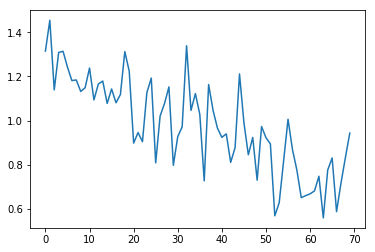

In [30]:
losses = losses[10:]
x_data = [i for i in range(len(losses))]
plt.plot(x_data, losses)